# Import Libraries

In [1]:
# !pip install -q torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 timm==0.9.12
!pip install "/kaggle/input/pytorch-2-1-3/pytorch_lightning-2.1.3-py3-none-any.whl"
!pip install "/kaggle/input/albumentation-package/albumentations-1.4.0-py3-none-any.whl"

Processing /kaggle/input/pytorch-2-1-3/pytorch_lightning-2.1.3-py3-none-any.whl
pytorch-lightning is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/albumentation-package/albumentations-1.4.0-py3-none-any.whl
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1


In [2]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.rcParams["figure.figsize"] = (12, 8)
from glob import glob
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# os.system('pip install -q bitsandbytes')

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.optim import Optimizer
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd.function import InplaceFunction
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

# PyTorch Lightning imports:
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.tuner.tuning import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping 
from pytorch_lightning.loggers import CSVLogger

from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import cv2
import albumentations as A
import timm
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

# Pipeline

## Directory Settings

In [4]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TEST_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'

## Ensembling Score

In [5]:
# B0
# oof_1 = pd.read_csv('/kaggle/input/hms-ckpts-2/b0/b0_greater2/b0_greater2.csv').rename({f'{i}':i for i in range(6)},axis=1).values   ## EFF b0
# oof_2 = pd.read_csv('/kaggle/input/hms-ckpts-2/b0/b0_allSamples/b0_allSamples.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b0 with all samples 
# oof_3 = pd.read_csv('/kaggle/input/hms-ckpts-2/b0/b0_3-20/b0_3-20.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b0 3-20
# oof_4 = pd.read_csv('/kaggle/input/hms-ckpts-2/b0/b0_PLs/b0_PLs.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b0 PLs
# oof_21 = pd.read_csv('/kaggle/input/hms-ckpts-3/b0/b0_Reverted2Stages.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b0 rev 2 stages

# Mobilenet
# oof_5 = pd.read_csv('/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_greater2/mobilenet_greater2.csv').rename({f'{i}':i for i in range(6)},axis=1).values  ## Mobilnet 0.536
oof_5 = pd.read_csv('/kaggle/input/hms-ckpts-3/mobilenet/mobilenet_Reverted2Stages.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## mobilenet rev 2 stages
oof_6 = pd.read_csv('/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_allsamples/mobilenet_allSamples.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## old mobilenet with all samples
# oof_7 = pd.read_csv('/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_3-20/mobilenet_3-20.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## old  mobilenet 3-20
oof_8 = pd.read_csv('/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_PLs/mobilenet_PLs.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## mobilenet PLs


# B4
# oof_9 = pd.read_csv('/kaggle/input/hms-ckpts-2/b4/b4_greater2/b4_greater2.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b4
oof_9 = pd.read_csv('/kaggle/input/hms-ckpts-3/b4/b4_Reverted2Stages.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b4 rev 2 stages
oof_10 = pd.read_csv('/kaggle/input/hms-ckpts-2/b4/b4_allsamples/b4_allSamples.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b4 with all samples 
# oof_11 = pd.read_csv('/kaggle/input/hms-ckpts-2/b4/b4_3-20/b4_3-20.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b4 3-20
oof_12 = pd.read_csv('/kaggle/input/hms-ckpts-2/b4/b4_PLs/b4_PLs.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b4 PLs

# B1
# oof_13 = pd.read_csv('/kaggle/input/hms-ckpts-2/b1/b1_greater2/b1_greater2.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b1 greater 2
oof_14 = pd.read_csv('/kaggle/input/hms-ckpts-2/b1/b1_allSample/b1_allsamples.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b1 all samples
oof_15 = pd.read_csv('/kaggle/input/hms-ckpts-2/b1/b1_PLs/b1_PLs.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b1 PLs
# oof_24 = pd.read_csv('/kaggle/input/hms-ckpts-3/b1/b1_Reverted2Stages.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b1 rev 2 stages

# B2
# oof_16 = pd.read_csv('/kaggle/input/temp-oof/b2_greater2.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b2 greater 2
# oof_17 = pd.read_csv('/kaggle/input/hms-ckpts-2/b2/b2_PLs/b2_PLs.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b2 PLs
oof_16 = pd.read_csv('/kaggle/input/hms-ckpts-3/b2/b2_Reverted2Stages.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b2 rev 2 stages

# B3
# oof_18 = pd.read_csv('/kaggle/input/temp-oof/b3_greater2.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b3 greater 2
oof_18 = pd.read_csv('/kaggle/input/hms-ckpts-3/b3/b3_Reverted2Stages.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b3 rev 2 stages
oof_19 = pd.read_csv('/kaggle/input/hms-ckpts-2/b3/b3_PLs/b3_PLs.csv').rename({f'{i}':i for i in range(6)},axis=1).values    ## b3 PLs


# Wavenet
oof_20 = pd.read_csv('/kaggle/input/hms-ckpts-2/wavenet/wavenet_PLs/wavenet_PLs_oof.csv').rename({f'{i}':i for i in range(6)},axis=1).values[:,1:]    ## wavenet PLs
# oof_27 = pd.read_csv('/kaggle/input/temp-oof/wavenet_Reverted2Stages.csv').rename({f'{i}':i for i in range(6)},axis=1).values   ## wavenet Reverted 2 Stages




y = pd.read_csv('/kaggle/input/hms-ckpts-2/y_true.csv').rename({f'{i}':i for i in range(6)},axis=1).values

subs = [oof_5,oof_6,oof_8,oof_9,oof_10,oof_12,oof_14,oof_15,oof_16,oof_18,oof_19,oof_20]

In [6]:
def comp_metric(y_pred,y_test):
    y_pred = pd.DataFrame(y_pred)
    y_pred['id'] = np.arange(len(y_pred))

    y_test = pd.DataFrame(y_test)
    y_test['id'] = np.arange(len(y_test))

    return score(solution=y_test, submission=y_pred, row_id_column_name='id')

In [7]:
from scipy.optimize import minimize

def KLD(weights, subs, y_true):
    ensemble_prediction = weights[0] * subs[0] 
    for i in range(1,len(weights)):
        ensemble_prediction += weights[i] * subs[i] 
    return comp_metric(ensemble_prediction, y_true)

# Initial weights (starting point for the optimization)
initial_weights = [1/len(subs) for i in range(len(subs))]

# Constraints: weights sum to 1 and are non-negative
constraints = ({'type': 'eq', 'fun': lambda w: sum(w) - 1})

# Bounds for each weight to be between 0 and 1
bounds = [(0, 1) for i in range(len(subs))]



# Perform optimization
opt_result = minimize(KLD, initial_weights, args=(subs, y),
                      method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = opt_result.x

print("Optimal weights:", optimal_weights)
print('Optimized Ensemble CV: ', KLD(optimal_weights, subs, y))

# Optimal weights: [0.10762404 0.02128592 0.0722603  0.15327434 0.02578453 0.14718503
#  0.10511396 0.09910654 0.02558858 0.05879324 0.08758314 0.09640038]
# Optimized Ensemble CV:  0.4573605733227234

Optimal weights: [0.10762404 0.02128592 0.0722603  0.15327434 0.02578453 0.14718503
 0.10511396 0.09910654 0.02558858 0.05879324 0.08758314 0.09640038]
Optimized Ensemble CV:  0.4573605733227234


## Data Loading

In [8]:
# ====================================================
# Data Loading
# ====================================================
df = pd.read_csv(TEST_PATH + 'test.csv')
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

print(f"test.shape: {df.shape}")
display(df.head())

test.shape: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [9]:
# READ ALL SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
files2 = os.listdir(PATH2)
print(f'There are {len(files2)} test spectrogram parquets')
    
spectrograms = {}
for i, f in enumerate(files2):
    if i % 100 == 0:
        print(i, ', ',end='')
    tmp = pd.read_parquet(f'{PATH2}{f}')
    name = int(f.split('.')[0])
    spectrograms[name] = tmp.iloc[:, 1:].values
    
# RENAME FOR DATALOADER
test_df = df.rename({'spectrogram_id': 'spec_id'}, axis=1)

There are 1 test spectrogram parquets
0 , 

In [10]:
import pywt, librosa

USE_WAVELET = None 

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]


# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)


def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret


def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE 
            mel_spec_db = np.log1p(-mel_spec_db)
            eps = 1e-6
            mel_spec_db = (mel_spec_db - 4.4) / 1 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

Converting Test EEG to Spectrograms...



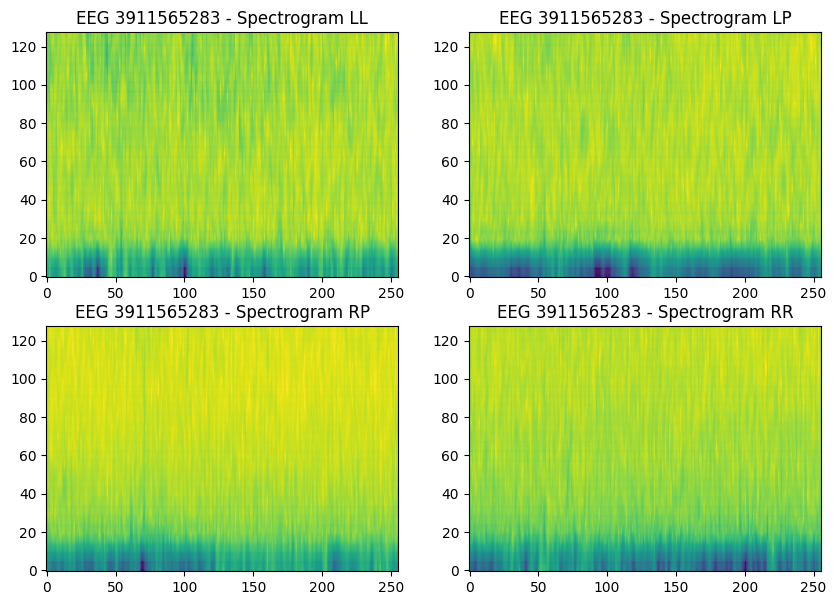

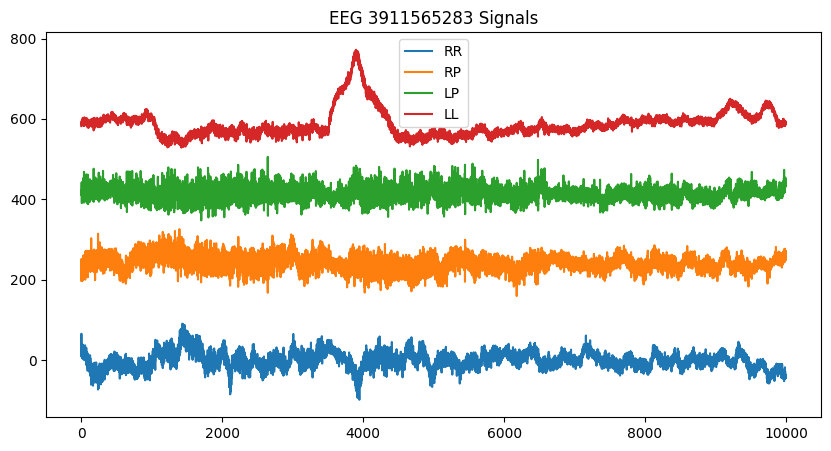


#########################



In [11]:
# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 1
EEG_IDS2 = test_df.eeg_id.unique()
all_eegs = {}

print('Converting Test EEG to Spectrograms...'); print()
for i, eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}{eeg_id}.parquet', i < DISPLAY)
    all_eegs[eeg_id] = img

## CFG

In [12]:
class CFG:
    competition = 'HMS'   # Competition Name
    seed = 42
########################################################################################################
    # Data
    batch_size = 32        
    valid_batch_size = 2 * batch_size
    num_workers = os.cpu_count()       # Threads in Data Loader
    target_cols = TARGETS
########################################################################################################
    # Training
    pretrained = False
    epochs = 4
########################################################################################################
    # Optimizer
    encoder_lr = 0.0013         # Pretrained Model lr  
    decoder_lr = 1.5e-5         # Custom Model lr  
    
    layerwise_learning_rate_decay = 1.0  
    eps = 1e-6                # Adam Parameters 
    betas=(0.9, 0.999)        # Adam Parameters
    weight_decay = 0.02
    lr_finder=False
########################################################################################################
    # Scheduler
    use_scheduler = True    # Use Scheduler
    scheduler = 'cosine'      # 'cosine' or 'linear' or 'cosine_hard'
    num_cycles = 0.5
    num_warmup_steps = 0
    sch_interval = 'step'    # 'step' or 'epoch'
########################################################################################################
    # CV
    n_fold=5
    trn_fold=list(range(n_fold))
########################################################################################################
    # Augmentation
    train_aug_list = [
    ]
    
    valid_aug_list = [
    ]

## Utils

In [13]:
# ====================================================
# Utils
# ====================================================
def comp_metric(y_pred,y_test):
    y_pred = pd.DataFrame(y_pred.cpu().numpy())
    y_pred['id'] = np.arange(len(y_pred))

    y_test = pd.DataFrame(y_test.cpu().numpy())
    y_test['id'] = np.arange(len(y_test))

    return score(solution=y_test, submission=y_pred, row_id_column_name='id')

def get_score(y_preds, y_trues):
    score = comp_metric(y_preds, y_trues)
    return score

seed_everything(seed=CFG.seed)

42

In [14]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)
    return aug

## Dataset

In [15]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x: y for y, x in TARS.items()}

In [16]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, cfg, data, train=True, transform=None, spectrograms=spectrograms, all_eegs=all_eegs):
        self.data  = data
        self.transforms = transform
        self.train = train
        self.cfg = cfg
        self.specs = spectrograms
        self.eeg_specs = all_eegs
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.__getitems__([index])
    
    def __getitems__(self,indices):
        
        X, y = self._generate_data(indices)
        
        if self.train:     ## Train
            if self.transforms: 
                for i in range(X.shape[0]):
                    X[i,] = self.transforms(image=X[i,])['image']
            return list(zip(X, y))
        
        else:            ## Test
            if self.transforms: 
                for i in range(X.shape[0]):
                    X[i,] = self.transforms(image=X[i,])['image']
            return X
        
        
    def _generate_data(self, indexes):
        X = np.zeros((len(indexes), 128, 256, 8),dtype='float32')
        y = np.zeros((len(indexes), 6),dtype='float32')
        img = np.ones((128, 256),dtype='float32')
        
        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.train: 
                r = int((row['min'] + row['max'])//4)
            else: 
                r = 0

            for k in range(4):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                img = self.specs[row.spec_id][r:r+300, k*100:(k+1)*100].T
                
                total_mean = -0.17722809101175144
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-6), np.exp(10))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                img = (img - 10) / (-6 + ep)
                img = np.nan_to_num(img, nan=total_mean)
                
                # CROP TO 256 TIME STEPS
                X[j, 14:-14, :, k] = img[:, 22:-22] / 2.0
        
            # EEG SPECTROGRAMS
            img = self.eeg_specs[row.eeg_id]
            X[j, :, :, 4:] = img
                
            if self.train:
                y[j,] = row[TARGETS]
            
        return X, y

## Model

#### Get optimizer and scheduler

In [17]:
def get_optimizer_params(model, encoder_lr, decoder_lr, layerwise_learning_rate_decay, weight_decay=0.0):
        param_optimizer = list(model[0].named_parameters()) + list(model[1].named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
        ]
                
        return optimizer_parameters
    
    
def get_scheduler(cfg, optimizer, len_train_folds):
    num_train_steps = int(len_train_folds / cfg.batch_size * cfg.epochs)
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
        )
    elif cfg.scheduler == 'cosine_hard':
        scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
        )
        
    return scheduler

# Models

## 1- B0

In [18]:
# ====================================================
# Model
# ====================================================
class CustomModel(LightningModule):
    def __init__(self, cfg, criterion, train_folds, valid_folds, fold, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.criterion = criterion
        self.train_folds = train_folds
        self.valid_folds = valid_folds
        self.fold = fold
        self.pretrained = pretrained
        self.val_step_outputs = []
        self.val_step_labels = []
        if self.cfg.lr_finder:
            self.lr = CFG.encoder_lr


        self.backbone1 = timm.create_model('efficientnet_b0', pretrained=False, in_chans=1)
        self.backbone2 = timm.create_model('efficientnet_b0', pretrained=False, in_chans=4)
        
        in_features = self.backbone1.num_features 
        self.fc = nn.Linear(in_features, len(CFG.target_cols))
                    
    def train_dataloader(self):
        train_dataset = TrainDataset(CFG, self.train_folds, transform=get_transforms('train', CFG))
        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  num_workers=CFG.num_workers,
                                  drop_last=True,
                                  pin_memory=True,
                                 )
        return train_loader
    
    
    def val_dataloader(self):
        valid_dataset = TrainDataset(CFG, self.valid_folds, transform=get_transforms('valid', CFG))
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.valid_batch_size,
                                  shuffle=False,
                                  num_workers=CFG.num_workers,
                                  drop_last=False,
                                 )
        return valid_loader
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.log_softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_outputs.append(y_preds)
        self.val_step_labels.append(labels)

        return loss

        
    def configure_optimizers(self):
        optimizer_parameters = get_optimizer_params([self.backbone1,self.backbone2],
                                                    encoder_lr=CFG.encoder_lr,
                                                    decoder_lr=CFG.decoder_lr,
                                                    layerwise_learning_rate_decay=CFG.layerwise_learning_rate_decay,
                                                    weight_decay=CFG.weight_decay)
        
        if self.cfg.use_8bit_optimizer:
            import bitsandbytes as bnb
            optimizer = bnb.optim.Adam8bit(optimizer_parameters,
                  lr=CFG.encoder_lr,
                  eps=CFG.eps,
                  betas=CFG.betas)
        else:
            optimizer = AdamW(optimizer_parameters,
                              lr=CFG.encoder_lr,
                              eps=CFG.eps,
                              betas=CFG.betas)
        
        scheduler = get_scheduler(CFG, optimizer, len(self.train_folds))
        lr_scheduler_dict = {"scheduler": scheduler, "interval": CFG.sch_interval}
        if self.cfg.use_scheduler:
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_dict}
        else:
            return {'optimizer': optimizer}
    
    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        
        val_KLD = get_score(all_preds, all_labels)
        self.log("KLD_val", val_KLD, on_step=False, on_epoch=True, prog_bar=True)
        
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}, KLD_val: {val_KLD}", flush=True)
           
    
    # The Model Architicture
    def forward(self, x):
        
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)

        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=3)

        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        
        
        # Pass each image through its respective backbone
        features1 = self.backbone1.forward_features(x1)
        features2 = self.backbone2.forward_features(x2)
        
        features1 = self.backbone1.forward_head(features1, pre_logits = True)
        features2 = self.backbone2.forward_head(features2, pre_logits = True)

        # Concatenate the features from both backbones
        combined_features = features1 * features2


        # Apply the final classification layer
        output = self.fc(combined_features)

        return output

## 2- Mobilenet

In [19]:
# ====================================================
# Model
# ====================================================
class CustomModel_2(LightningModule):
    def __init__(self, cfg, criterion, train_folds, valid_folds, fold, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.criterion = criterion
        self.train_folds = train_folds
        self.valid_folds = valid_folds
        self.fold = fold
        self.pretrained = pretrained
        self.val_step_outputs = []
        self.val_step_labels = []
        if self.cfg.lr_finder:
            self.lr = CFG.encoder_lr

        # Create two separate ResNet34d backbones for each image
        self.backbone1 = models.mobilenet_v3_large()
        self.backbone2 = models.mobilenet_v3_large()
        
        # Disable dropout
        self.disable_dropout(self.backbone1)
        self.disable_dropout(self.backbone2)
        
        self.in_features = 1000  # Combine features from both backbones
        self.fc = nn.Linear(self.in_features, len(CFG.target_cols))
        
    def disable_dropout(self,model):
        for module in model.modules():
            if isinstance(module, torch.nn.Dropout):
                module.p = 0.0  # Set dropout probability to 0    
                    
    def train_dataloader(self):
        train_dataset = TrainDataset(CFG, self.train_folds, transform=get_transforms('train', CFG), mixup=True)
        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  num_workers=CFG.num_workers,
                                  drop_last=True,
                                  pin_memory=True,
                                 )
        return train_loader
    
    
    def val_dataloader(self):
        valid_dataset = TrainDataset(CFG, self.valid_folds, transform=get_transforms('valid', CFG))
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.valid_batch_size,
                                  shuffle=False,
                                  num_workers=CFG.num_workers,
                                  drop_last=False,
                                 )
        return valid_loader
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.log_softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_outputs.append(y_preds)
        self.val_step_labels.append(labels)

        return loss

        
    def configure_optimizers(self):
        optimizer_parameters = get_optimizer_params([self.backbone1,self.backbone2],
                                                    encoder_lr=CFG.encoder_lr,
                                                    decoder_lr=CFG.decoder_lr,
                                                    layerwise_learning_rate_decay=CFG.layerwise_learning_rate_decay,
                                                    weight_decay=CFG.weight_decay)
        
        if self.cfg.use_8bit_optimizer:
            import bitsandbytes as bnb
            optimizer = bnb.optim.Adam8bit(optimizer_parameters,
                  lr=CFG.encoder_lr,
                  eps=CFG.eps,
                  betas=CFG.betas)
        else:
            optimizer = AdamW(optimizer_parameters,
                              lr=CFG.encoder_lr,
                              eps=CFG.eps,
                              betas=CFG.betas)
        
        scheduler = get_scheduler(CFG, optimizer, len(self.train_folds))
        lr_scheduler_dict = {"scheduler": scheduler, "interval": CFG.sch_interval}
        if self.cfg.use_scheduler:
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_dict}
        else:
            return {'optimizer': optimizer}
    
    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        
        val_KLD = get_score(all_preds, all_labels)
        self.log("KLD_val", val_KLD, on_step=False, on_epoch=True, prog_bar=True)
        
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}, KLD_val: {val_KLD}", flush=True)
           
    
    # The Model Architicture
    def forward(self, x):
        
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)

        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=1)

        x1 = torch.concat([x1, x1, x1], dim=3)
        x2 = torch.concat([x2, x2, x2], dim=3)
        
        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        
        
        # Pass each image through its respective backbone
        features1 = self.backbone1(x1)
        features2 = self.backbone2(x2)
        
        # Concatenate the features from both backbones
        combined_features = features1 * features2

        # Apply the final classification layer
        output = self.fc(combined_features)

        return output

## 3- B4

In [20]:
# ====================================================
# Model
# ====================================================
class CustomModel_3(LightningModule):
    def __init__(self, cfg, criterion, train_folds, valid_folds, fold, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.criterion = criterion
        self.train_folds = train_folds
        self.valid_folds = valid_folds
        self.fold = fold
        self.pretrained = pretrained
        self.val_step_outputs = []
        self.val_step_labels = []
        if self.cfg.lr_finder:
            self.lr = CFG.encoder_lr

        self.backbone1 = timm.create_model('efficientnet_b4', pretrained=False, in_chans=1)
        self.backbone2 = timm.create_model('efficientnet_b4', pretrained=False, in_chans=4)
    
        in_features = self.backbone1.num_features 
        self.fc = nn.Linear(in_features, len(CFG.target_cols))
                    
    def train_dataloader(self):
        train_dataset = TrainDataset(CFG, self.train_folds, transform=get_transforms('train', CFG))
        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  num_workers=CFG.num_workers,
                                  drop_last=True,
                                  pin_memory=True,
                                 )
        return train_loader
    
    
    def val_dataloader(self):
        valid_dataset = TrainDataset(CFG, self.valid_folds, transform=get_transforms('valid', CFG))
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.valid_batch_size,
                                  shuffle=False,
                                  num_workers=CFG.num_workers,
                                  drop_last=False,
                                 )
        return valid_loader
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.log_softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_outputs.append(y_preds)
        self.val_step_labels.append(labels)

        return loss

        
    def configure_optimizers(self):
        optimizer_parameters = get_optimizer_params([self.backbone1,self.backbone2],
                                                    encoder_lr=CFG.encoder_lr,
                                                    decoder_lr=CFG.decoder_lr,
                                                    layerwise_learning_rate_decay=CFG.layerwise_learning_rate_decay,
                                                    weight_decay=CFG.weight_decay)
        
        if self.cfg.use_8bit_optimizer:
            import bitsandbytes as bnb
            optimizer = bnb.optim.Adam8bit(optimizer_parameters,
                  lr=CFG.encoder_lr,
                  eps=CFG.eps,
                  betas=CFG.betas)
        else:
            optimizer = AdamW(optimizer_parameters,
                              lr=CFG.encoder_lr,
                              eps=CFG.eps,
                              betas=CFG.betas)
        
        scheduler = get_scheduler(CFG, optimizer, len(self.train_folds))
        lr_scheduler_dict = {"scheduler": scheduler, "interval": CFG.sch_interval}
        if self.cfg.use_scheduler:
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_dict}
        else:
            return {'optimizer': optimizer}
    
    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        
        val_KLD = get_score(all_preds, all_labels)
        self.log("KLD_val", val_KLD, on_step=False, on_epoch=True, prog_bar=True)
        
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}, KLD_val: {val_KLD}", flush=True)
           
    
    # The Model Architicture
    def forward(self, x):
        
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)

        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=3)

        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        
        
        # Pass each image through its respective backbone
        features1 = self.backbone1.forward_features(x1)
        features2 = self.backbone2.forward_features(x2)
        
        features1 = self.backbone1.forward_head(features1, pre_logits = True)
        features2 = self.backbone2.forward_head(features2, pre_logits = True)

        # Concatenate the features from both backbones
        combined_features = features1 * features2


        # Apply the final classification layer
        output = self.fc(combined_features)

        return output

## 4- B1

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel_4(LightningModule):
    def __init__(self, cfg, criterion, train_folds, valid_folds, fold, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.criterion = criterion
        self.train_folds = train_folds
        self.valid_folds = valid_folds
        self.fold = fold
        self.pretrained = pretrained
        self.val_step_outputs = []
        self.val_step_labels = []
        if self.cfg.lr_finder:
            self.lr = CFG.encoder_lr

        self.backbone1 = timm.create_model('efficientnet_b1', pretrained=False, in_chans=1)
        self.backbone2 = timm.create_model('efficientnet_b1', pretrained=False, in_chans=4)
    
        in_features = self.backbone1.num_features 
        self.fc = nn.Linear(in_features, len(CFG.target_cols))
                    
    def train_dataloader(self):
        train_dataset = TrainDataset(CFG, self.train_folds, transform=get_transforms('train', CFG))
        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  num_workers=CFG.num_workers,
                                  drop_last=True,
                                  pin_memory=True,
                                 )
        return train_loader
    
    
    def val_dataloader(self):
        valid_dataset = TrainDataset(CFG, self.valid_folds, transform=get_transforms('valid', CFG))
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.valid_batch_size,
                                  shuffle=False,
                                  num_workers=CFG.num_workers,
                                  drop_last=False,
                                 )
        return valid_loader
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.log_softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_outputs.append(y_preds)
        self.val_step_labels.append(labels)

        return loss

        
    def configure_optimizers(self):
        optimizer_parameters = get_optimizer_params([self.backbone1,self.backbone2],
                                                    encoder_lr=CFG.encoder_lr,
                                                    decoder_lr=CFG.decoder_lr,
                                                    layerwise_learning_rate_decay=CFG.layerwise_learning_rate_decay,
                                                    weight_decay=CFG.weight_decay)
        
        if self.cfg.use_8bit_optimizer:
            import bitsandbytes as bnb
            optimizer = bnb.optim.Adam8bit(optimizer_parameters,
                  lr=CFG.encoder_lr,
                  eps=CFG.eps,
                  betas=CFG.betas)
        else:
            optimizer = AdamW(optimizer_parameters,
                              lr=CFG.encoder_lr,
                              eps=CFG.eps,
                              betas=CFG.betas)
        
        scheduler = get_scheduler(CFG, optimizer, len(self.train_folds))
        lr_scheduler_dict = {"scheduler": scheduler, "interval": CFG.sch_interval}
        if self.cfg.use_scheduler:
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_dict}
        else:
            return {'optimizer': optimizer}
    
    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        
        val_KLD = get_score(all_preds, all_labels)
        self.log("KLD_val", val_KLD, on_step=False, on_epoch=True, prog_bar=True)
        
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}, KLD_val: {val_KLD}", flush=True)
           
    
    # The Model Architicture
    def forward(self, x):
        
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)

        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=3)

        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        
        
        # Pass each image through its respective backbone
        features1 = self.backbone1.forward_features(x1)
        features2 = self.backbone2.forward_features(x2)
        
        features1 = self.backbone1.forward_head(features1, pre_logits = True)
        features2 = self.backbone2.forward_head(features2, pre_logits = True)

        # Concatenate the features from both backbones
        combined_features = features1 * features2


        # Apply the final classification layer
        output = self.fc(combined_features)

        return output

## 5- B2

In [22]:
# ====================================================
# Model
# ====================================================
class CustomModel_5(LightningModule):
    def __init__(self, cfg, criterion, train_folds, valid_folds, fold, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.criterion = criterion
        self.train_folds = train_folds
        self.valid_folds = valid_folds
        self.fold = fold
        self.pretrained = pretrained
        self.val_step_outputs = []
        self.val_step_labels = []
        if self.cfg.lr_finder:
            self.lr = CFG.encoder_lr

        self.backbone1 = timm.create_model('efficientnet_b2', pretrained=False, in_chans=1)
        self.backbone2 = timm.create_model('efficientnet_b2', pretrained=False, in_chans=4)
    
        in_features = self.backbone1.num_features 
        self.fc = nn.Linear(in_features, len(CFG.target_cols))
                    
    def train_dataloader(self):
        train_dataset = TrainDataset(CFG, self.train_folds, transform=get_transforms('train', CFG))
        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  num_workers=CFG.num_workers,
                                  drop_last=True,
                                  pin_memory=True,
                                 )
        return train_loader
    
    
    def val_dataloader(self):
        valid_dataset = TrainDataset(CFG, self.valid_folds, transform=get_transforms('valid', CFG))
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.valid_batch_size,
                                  shuffle=False,
                                  num_workers=CFG.num_workers,
                                  drop_last=False,
                                 )
        return valid_loader
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.log_softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_outputs.append(y_preds)
        self.val_step_labels.append(labels)

        return loss

        
    def configure_optimizers(self):
        optimizer_parameters = get_optimizer_params([self.backbone1,self.backbone2],
                                                    encoder_lr=CFG.encoder_lr,
                                                    decoder_lr=CFG.decoder_lr,
                                                    layerwise_learning_rate_decay=CFG.layerwise_learning_rate_decay,
                                                    weight_decay=CFG.weight_decay)
        
        if self.cfg.use_8bit_optimizer:
            import bitsandbytes as bnb
            optimizer = bnb.optim.Adam8bit(optimizer_parameters,
                  lr=CFG.encoder_lr,
                  eps=CFG.eps,
                  betas=CFG.betas)
        else:
            optimizer = AdamW(optimizer_parameters,
                              lr=CFG.encoder_lr,
                              eps=CFG.eps,
                              betas=CFG.betas)
        
        scheduler = get_scheduler(CFG, optimizer, len(self.train_folds))
        lr_scheduler_dict = {"scheduler": scheduler, "interval": CFG.sch_interval}
        if self.cfg.use_scheduler:
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_dict}
        else:
            return {'optimizer': optimizer}
    
    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        
        val_KLD = get_score(all_preds, all_labels)
        self.log("KLD_val", val_KLD, on_step=False, on_epoch=True, prog_bar=True)
        
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}, KLD_val: {val_KLD}", flush=True)
           
    
    # The Model Architicture
    def forward(self, x):
        
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)

        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=3)

        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        
        
        # Pass each image through its respective backbone
        features1 = self.backbone1.forward_features(x1)
        features2 = self.backbone2.forward_features(x2)
        
        features1 = self.backbone1.forward_head(features1, pre_logits = True)
        features2 = self.backbone2.forward_head(features2, pre_logits = True)

        # Concatenate the features from both backbones
        combined_features = features1 * features2


        # Apply the final classification layer
        output = self.fc(combined_features)

        return output

## 6- B3

In [23]:
# ====================================================
# Model
# ====================================================
class CustomModel_6(LightningModule):
    def __init__(self, cfg, criterion, train_folds, valid_folds, fold, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.criterion = criterion
        self.train_folds = train_folds
        self.valid_folds = valid_folds
        self.fold = fold
        self.pretrained = pretrained
        self.val_step_outputs = []
        self.val_step_labels = []
        if self.cfg.lr_finder:
            self.lr = CFG.encoder_lr

        self.backbone1 = timm.create_model('efficientnet_b3', pretrained=False, in_chans=1)
        self.backbone2 = timm.create_model('efficientnet_b3', pretrained=False, in_chans=4)
    
        in_features = self.backbone1.num_features 
        self.fc = nn.Linear(in_features, len(CFG.target_cols))
                    
    def train_dataloader(self):
        train_dataset = TrainDataset(CFG, self.train_folds, transform=get_transforms('train', CFG))
        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  num_workers=CFG.num_workers,
                                  drop_last=True,
                                  pin_memory=True,
                                 )
        return train_loader
    
    
    def val_dataloader(self):
        valid_dataset = TrainDataset(CFG, self.valid_folds, transform=get_transforms('valid', CFG))
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.valid_batch_size,
                                  shuffle=False,
                                  num_workers=CFG.num_workers,
                                  drop_last=False,
                                 )
        return valid_loader
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.log_softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch[0], batch[1]
        
        y_preds = self(inputs)
        y_preds = F.softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_outputs.append(y_preds)
        self.val_step_labels.append(labels)

        return loss

        
    def configure_optimizers(self):
        optimizer_parameters = get_optimizer_params([self.backbone1,self.backbone2],
                                                    encoder_lr=CFG.encoder_lr,
                                                    decoder_lr=CFG.decoder_lr,
                                                    layerwise_learning_rate_decay=CFG.layerwise_learning_rate_decay,
                                                    weight_decay=CFG.weight_decay)
        
        if self.cfg.use_8bit_optimizer:
            import bitsandbytes as bnb
            optimizer = bnb.optim.Adam8bit(optimizer_parameters,
                  lr=CFG.encoder_lr,
                  eps=CFG.eps,
                  betas=CFG.betas)
        else:
            optimizer = AdamW(optimizer_parameters,
                              lr=CFG.encoder_lr,
                              eps=CFG.eps,
                              betas=CFG.betas)
        
        scheduler = get_scheduler(CFG, optimizer, len(self.train_folds))
        lr_scheduler_dict = {"scheduler": scheduler, "interval": CFG.sch_interval}
        if self.cfg.use_scheduler:
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_dict}
        else:
            return {'optimizer': optimizer}
    
    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        
        val_KLD = get_score(all_preds, all_labels)
        self.log("KLD_val", val_KLD, on_step=False, on_epoch=True, prog_bar=True)
        
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}, KLD_val: {val_KLD}", flush=True)
           
    
    # The Model Architicture
    def forward(self, x):
        
        x1 = [x[:, :, :, i:i+1] for i in range(4)]
        x1 = torch.concat(x1, dim=1)

        x2 = [x[:, :, :, i+4:i+5] for i in range(4)]
        x2 = torch.concat(x2, dim=3)

        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        
        
        # Pass each image through its respective backbone
        features1 = self.backbone1.forward_features(x1)
        features2 = self.backbone2.forward_features(x2)
        
        features1 = self.backbone1.forward_head(features1, pre_logits = True)
        features2 = self.backbone2.forward_head(features2, pre_logits = True)

        # Concatenate the features from both backbones
        combined_features = features1 * features2


        # Apply the final classification layer
        output = self.fc(combined_features)

        return output

# Inference

In [24]:
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader), desc='Inference ')
    for step, images in tk0:
        images = images.to(device, dtype=torch.float) 
        with torch.no_grad():
            y_preds = model(images)
            y_preds = torch.softmax(y_preds, dim=1).cpu().numpy()
        preds.append(y_preds)
    return preds

In [25]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class TimeShift(ImageOnlyTransform):
    def __init__(self, shift_max, p=0.5):
        super(TimeShift, self).__init__(always_apply=False, p=p)
        self.shift_max = shift_max

    def apply(self, img, **params):
        # Calculate shift value as a fraction of the image width
        shift = np.random.uniform(-self.shift_max, self.shift_max)
        shift = int(shift * img.shape[1])  # img.shape should be (Height, Width, Channels)
        
        # Pad and shift the spectrogram
        if shift > 0:
            img = np.pad(img, ((0, 0), (shift, 0), (0, 0)), mode='constant')[:, :-shift, :]
        elif shift < 0:
            img = np.pad(img, ((0, 0), (0, -shift), (0, 0)), mode='constant')[:, -shift:, :]
        return img

    def get_transform_init_args_names(self):
        return ("shift_max",)
    
params4mask = {
    "num_masks_x": (1, 3),
    "num_masks_y": (1, 3),    
    "mask_y_length": (5, 20),
    "mask_x_length": (5, 20),
    "fill_value": 0,
}
    
aug_vflip = [
    A.VerticalFlip(p=1.0),
]
aug_time_shift = [
    TimeShift(shift_max=0.1, p=1.0),
]
aug_xy_mask = [
    A.XYMasking(**params4mask, p=1.0),
]

def get_transforms_TTA(augment_list):
    aug = A.Compose(augment_list)
    return aug

## 1- B0

In [26]:
# model = CustomModel(cfg=CFG,
#                     criterion=None,
#                     train_folds=None,
#                     valid_folds=None,
#                     fold=None,
#                     pretrained=CFG.pretrained)

# valid_dataset_original = TrainDataset(CFG, data=test_df, train=False, 
#                              transform=get_transforms('valid', CFG))
# valid_loader_original = DataLoader(valid_dataset_original,
#                           batch_size=CFG.valid_batch_size,
#                           shuffle=False,
#                           num_workers=CFG.num_workers,
#                           drop_last=False)

# valid_dataset_vflip = TrainDataset(CFG, data=test_df, train=False, 
#                              transform=get_transforms_TTA(aug_vflip))
# valid_loader_vflip = DataLoader(valid_dataset_vflip,
#                           batch_size=CFG.valid_batch_size,
#                           shuffle=False,
#                           num_workers=CFG.num_workers,
#                           drop_last=False)

# valid_dataset_time_shift = TrainDataset(CFG, data=test_df, train=False, 
#                              transform=get_transforms_TTA(aug_time_shift))
# valid_loader_time_shift = DataLoader(valid_dataset_time_shift,
#                           batch_size=CFG.valid_batch_size,
#                           shuffle=False,
#                           num_workers=CFG.num_workers,
#                           drop_last=False)
# valid_dataset_xy_mask = TrainDataset(CFG, data=test_df, train=False, 
#                              transform=get_transforms_TTA(aug_xy_mask))
# valid_loader_xy_mask = DataLoader(valid_dataset_xy_mask,
#                           batch_size=CFG.valid_batch_size,
#                           shuffle=False,
#                           num_workers=CFG.num_workers,
#                           drop_last=False)

### >= 2

In [27]:
# predictions_1 = []
# predictions_2 = []
# predictions_3 = []
# predictions_4 = []

# checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b0/b0_greater2"
# checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
# for checkpoint_path in tqdm(checkpoint_paths):
#     print(checkpoint_path)
#     model = CustomModel.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
#     prediction_1 = inference_fn(valid_loader_original, model, device)
#     prediction_2 = inference_fn(valid_loader_vflip, model, device)
#     prediction_3 = inference_fn(valid_loader_time_shift, model, device)
#     prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
#     prediction_1 = np.concatenate(prediction_1)
#     predictions_1.append(prediction_1)
#     prediction_2 = np.concatenate(prediction_2)
#     predictions_2.append(prediction_2)
#     prediction_3 = np.concatenate(prediction_3)
#     predictions_3.append(prediction_3)
#     prediction_4 = np.concatenate(prediction_4)
#     predictions_4.append(prediction_4)
#     del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
#     torch.cuda.empty_cache()

    
# predictions_1 = np.mean(predictions_1,axis=0)
# predictions_2 = np.mean(predictions_2,axis=0)
# predictions_3 = np.mean(predictions_3,axis=0)
# predictions_4 = np.mean(predictions_4,axis=0)

### All samples

In [28]:
# predictions_5 = []
# predictions_6 = []
# predictions_7 = []
# predictions_8 = []

# checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b0/b0_allSamples"
# checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
# for checkpoint_path in tqdm(checkpoint_paths):
#     print(checkpoint_path)
#     model = CustomModel.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
#     prediction_1 = inference_fn(valid_loader_original, model, device)
#     prediction_2 = inference_fn(valid_loader_vflip, model, device)
#     prediction_3 = inference_fn(valid_loader_time_shift, model, device)
#     prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
#     prediction_1 = np.concatenate(prediction_1)
#     predictions_5.append(prediction_1)
#     prediction_2 = np.concatenate(prediction_2)
#     predictions_6.append(prediction_2)
#     prediction_3 = np.concatenate(prediction_3)
#     predictions_7.append(prediction_3)
#     prediction_4 = np.concatenate(prediction_4)
#     predictions_8.append(prediction_4)
#     del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
#     torch.cuda.empty_cache()

    
# predictions_5 = np.mean(predictions_5,axis=0)
# predictions_6 = np.mean(predictions_6,axis=0)
# predictions_7 = np.mean(predictions_7,axis=0)
# predictions_8 = np.mean(predictions_8,axis=0)

### 3-20

In [29]:
# predictions_9 = []
# predictions_10 = []
# predictions_11 = []
# predictions_12 = []

# checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b0/b0_3-20"
# checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
# for checkpoint_path in tqdm(checkpoint_paths):
#     print(checkpoint_path)
#     model = CustomModel.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
#     prediction_1 = inference_fn(valid_loader_original, model, device)
#     prediction_2 = inference_fn(valid_loader_vflip, model, device)
#     prediction_3 = inference_fn(valid_loader_time_shift, model, device)
#     prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
#     prediction_1 = np.concatenate(prediction_1)
#     predictions_9.append(prediction_1)
#     prediction_2 = np.concatenate(prediction_2)
#     predictions_10.append(prediction_2)
#     prediction_3 = np.concatenate(prediction_3)
#     predictions_11.append(prediction_3)
#     prediction_4 = np.concatenate(prediction_4)
#     predictions_12.append(prediction_4)
#     del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
#     torch.cuda.empty_cache()

    
# predictions_9 = np.mean(predictions_9,axis=0)
# predictions_10 = np.mean(predictions_10,axis=0)
# predictions_11 = np.mean(predictions_11,axis=0)
# predictions_12 = np.mean(predictions_12,axis=0)

### PLs

In [30]:
# predictions_13 = []
# predictions_14 = []
# predictions_15 = []
# predictions_16 = []

# checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b0/b0_PLs"
# checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
# for checkpoint_path in tqdm(checkpoint_paths):
#     print(checkpoint_path)
#     model = CustomModel.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
#     prediction_1 = inference_fn(valid_loader_original, model, device)
#     prediction_2 = inference_fn(valid_loader_vflip, model, device)
#     prediction_3 = inference_fn(valid_loader_time_shift, model, device)
#     prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
#     prediction_1 = np.concatenate(prediction_1)
#     predictions_13.append(prediction_1)
#     prediction_2 = np.concatenate(prediction_2)
#     predictions_14.append(prediction_2)
#     prediction_3 = np.concatenate(prediction_3)
#     predictions_15.append(prediction_3)
#     prediction_4 = np.concatenate(prediction_4)
#     predictions_16.append(prediction_4)
#     del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
#     torch.cuda.empty_cache()

    
# predictions_13 = np.mean(predictions_13,axis=0)
# predictions_14 = np.mean(predictions_14,axis=0)
# predictions_15 = np.mean(predictions_15,axis=0)
# predictions_16 = np.mean(predictions_16,axis=0)

# del valid_loader_original, valid_loader_vflip, valid_loader_time_shift, valid_loader_xy_mask

## 2- Mobilenet

In [31]:
model = CustomModel_2(cfg=CFG,
                    criterion=None,
                    train_folds=None,
                    valid_folds=None,
                    fold=None,
                    pretrained=CFG.pretrained)

valid_dataset_original = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms('valid', CFG))
valid_loader_original = DataLoader(valid_dataset_original,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_vflip = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_vflip))
valid_loader_vflip = DataLoader(valid_dataset_vflip,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_time_shift = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_time_shift))
valid_loader_time_shift = DataLoader(valid_dataset_time_shift,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)
valid_dataset_xy_mask = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_xy_mask))
valid_loader_xy_mask = DataLoader(valid_dataset_xy_mask,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

### Reverted 2 Stages

In [32]:
predictions_17 = []
predictions_18 = []
predictions_19 = []
predictions_20 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-3/mobilenet"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_2.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_5 = inference_fn(valid_loader_original, model, device)
    prediction_6 = inference_fn(valid_loader_vflip, model, device)
    prediction_7 = inference_fn(valid_loader_time_shift, model, device)
    prediction_8 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_5 = np.concatenate(prediction_5)
    predictions_17.append(prediction_5)
    prediction_6 = np.concatenate(prediction_6)
    predictions_18.append(prediction_6)
    prediction_7 = np.concatenate(prediction_7)
    predictions_19.append(prediction_7)
    prediction_8 = np.concatenate(prediction_8)
    predictions_20.append(prediction_8)
    del model, prediction_5, prediction_6, prediction_7, prediction_8; gc.collect()
    torch.cuda.empty_cache()


predictions_17 = np.mean(predictions_17,axis=0)
predictions_18 = np.mean(predictions_18,axis=0)
predictions_19 = np.mean(predictions_19,axis=0)
predictions_20 = np.mean(predictions_20,axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/mobilenet/stage_2_model-f0-loss=val_loss=1.4540-KLD_loss=KLD_val=0.5079.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/mobilenet/stage_2_model-f2-loss=val_loss=1.4400-KLD_loss=KLD_val=0.5152.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/mobilenet/stage_2_model-f3-loss=val_loss=1.4766-KLD_loss=KLD_val=0.5805.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/mobilenet/stage_2_model-f4-loss=val_loss=1.4732-KLD_loss=KLD_val=0.5413.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/mobilenet/stage_2_model-f1-loss=val_loss=1.4653-KLD_loss=KLD_val=0.4966.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

### All samples

In [33]:
predictions_21 = []
predictions_22 = []
predictions_23 = []
predictions_24 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_allsamples"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_2.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_5 = inference_fn(valid_loader_original, model, device)
    prediction_6 = inference_fn(valid_loader_vflip, model, device)
    prediction_7 = inference_fn(valid_loader_time_shift, model, device)
    prediction_8 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_5 = np.concatenate(prediction_5)
    predictions_21.append(prediction_5)
    prediction_6 = np.concatenate(prediction_6)
    predictions_22.append(prediction_6)
    prediction_7 = np.concatenate(prediction_7)
    predictions_23.append(prediction_7)
    prediction_8 = np.concatenate(prediction_8)
    predictions_24.append(prediction_8)
    del model, prediction_5, prediction_6, prediction_7, prediction_8; gc.collect()
    torch.cuda.empty_cache()


predictions_21 = np.mean(predictions_21,axis=0)
predictions_22 = np.mean(predictions_22,axis=0)
predictions_23 = np.mean(predictions_23,axis=0)
predictions_24 = np.mean(predictions_24,axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_allsamples/model-f2-loss=val_loss=1.4446-KLD_loss=KLD_val=0.5573.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_allsamples/model-f1-loss=val_loss=1.4803-KLD_loss=KLD_val=0.6108.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_allsamples/model-f4-loss=val_loss=1.4644-KLD_loss=KLD_val=0.5704.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_allsamples/model-f0-loss=val_loss=1.4525-KLD_loss=KLD_val=0.5601.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_allsamples/model-f3-loss=val_loss=1.4636-KLD_loss=KLD_val=0.6373.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

### 3-20

In [34]:
# predictions_25 = []
# predictions_26 = []
# predictions_27 = []
# predictions_28 = []


# checkpoint_dir = f"/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_3-20"
# checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
# for checkpoint_path in tqdm(checkpoint_paths):
#     print(checkpoint_path)
#     model = CustomModel_2.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
#     prediction_5 = inference_fn(valid_loader_original, model, device)
#     prediction_6 = inference_fn(valid_loader_vflip, model, device)
#     prediction_7 = inference_fn(valid_loader_time_shift, model, device)
#     prediction_8 = inference_fn(valid_loader_xy_mask, model, device)
    
#     prediction_5 = np.concatenate(prediction_5)
#     predictions_25.append(prediction_5)
#     prediction_6 = np.concatenate(prediction_6)
#     predictions_26.append(prediction_6)
#     prediction_7 = np.concatenate(prediction_7)
#     predictions_27.append(prediction_7)
#     prediction_8 = np.concatenate(prediction_8)
#     predictions_28.append(prediction_8)
#     del model, prediction_5, prediction_6, prediction_7, prediction_8; gc.collect()
#     torch.cuda.empty_cache()


# predictions_25 = np.mean(predictions_25,axis=0)
# predictions_26 = np.mean(predictions_26,axis=0)
# predictions_27 = np.mean(predictions_27,axis=0)
# predictions_28 = np.mean(predictions_28,axis=0)

### PLs

In [35]:
predictions_29 = []
predictions_30 = []
predictions_31 = []
predictions_32 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_PLs"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_2.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_5 = inference_fn(valid_loader_original, model, device)
    prediction_6 = inference_fn(valid_loader_vflip, model, device)
    prediction_7 = inference_fn(valid_loader_time_shift, model, device)
    prediction_8 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_5 = np.concatenate(prediction_5)
    predictions_29.append(prediction_5)
    prediction_6 = np.concatenate(prediction_6)
    predictions_30.append(prediction_6)
    prediction_7 = np.concatenate(prediction_7)
    predictions_31.append(prediction_7)
    prediction_8 = np.concatenate(prediction_8)
    predictions_32.append(prediction_8)
    del model, prediction_5, prediction_6, prediction_7, prediction_8; gc.collect()
    torch.cuda.empty_cache()


predictions_29 = np.mean(predictions_29,axis=0)
predictions_30 = np.mean(predictions_30,axis=0)
predictions_31 = np.mean(predictions_31,axis=0)
predictions_32 = np.mean(predictions_32,axis=0)

del valid_loader_original, valid_loader_vflip, valid_loader_time_shift, valid_loader_xy_mask

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_PLs/model-f3-loss=val_loss=1.4768-KLD_loss=KLD_val=0.5564.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_PLs/model-f4-loss=val_loss=1.4804-KLD_loss=KLD_val=0.5065.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_PLs/model-f1-loss=val_loss=1.4770-KLD_loss=KLD_val=0.4858.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_PLs/model-f0-loss=val_loss=1.4632-KLD_loss=KLD_val=0.4898.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/mobilenet/mobilenet_PLs/model-f2-loss=val_loss=1.4479-KLD_loss=KLD_val=0.5008.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

## 3- B4

In [36]:
model = CustomModel_3(cfg=CFG,
                    criterion=None,
                    train_folds=None,
                    valid_folds=None,
                    fold=None,
                    pretrained=CFG.pretrained)

valid_dataset_original = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms('valid', CFG))
valid_loader_original = DataLoader(valid_dataset_original,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_vflip = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_vflip))
valid_loader_vflip = DataLoader(valid_dataset_vflip,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_time_shift = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_time_shift))
valid_loader_time_shift = DataLoader(valid_dataset_time_shift,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)
valid_dataset_xy_mask = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_xy_mask))
valid_loader_xy_mask = DataLoader(valid_dataset_xy_mask,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

### Reverted 2 Stages

In [37]:
predictions_33 = []
predictions_34 = []
predictions_35 = []
predictions_36 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-3/b4"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_3.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_1 = inference_fn(valid_loader_original, model, device)
    prediction_2 = inference_fn(valid_loader_vflip, model, device)
    prediction_3 = inference_fn(valid_loader_time_shift, model, device)
    prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_1 = np.concatenate(prediction_1)
    predictions_33.append(prediction_1)
    prediction_2 = np.concatenate(prediction_2)
    predictions_34.append(prediction_2)
    prediction_3 = np.concatenate(prediction_3)
    predictions_35.append(prediction_3)
    prediction_4 = np.concatenate(prediction_4)
    predictions_36.append(prediction_4)
    del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
    torch.cuda.empty_cache()

predictions_33 = np.mean(predictions_33,axis=0)
predictions_34 = np.mean(predictions_34,axis=0)
predictions_35 = np.mean(predictions_35,axis=0)
predictions_36 = np.mean(predictions_36,axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b4/stage_2_model-f3-loss=val_loss=1.4282-KLD_loss=KLD_val=0.6614.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b4/stage_2_model-f4-loss=val_loss=1.4093-KLD_loss=KLD_val=0.5869.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b4/stage_2_model-f0-loss=val_loss=1.3991-KLD_loss=KLD_val=0.5037.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b4/stage_2_model-f2-loss=val_loss=1.3826-KLD_loss=KLD_val=0.5791.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b4/stage_2_model-f1-loss=val_loss=1.4248-KLD_loss=KLD_val=0.5630.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

### All samples

In [38]:
predictions_37 = []
predictions_38 = []
predictions_39 = []
predictions_40 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b4/b4_allsamples"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_3.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_1 = inference_fn(valid_loader_original, model, device)
    prediction_2 = inference_fn(valid_loader_vflip, model, device)
    prediction_3 = inference_fn(valid_loader_time_shift, model, device)
    prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_1 = np.concatenate(prediction_1)
    predictions_37.append(prediction_1)
    prediction_2 = np.concatenate(prediction_2)
    predictions_38.append(prediction_2)
    prediction_3 = np.concatenate(prediction_3)
    predictions_39.append(prediction_3)
    prediction_4 = np.concatenate(prediction_4)
    predictions_40.append(prediction_4)
    del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
    torch.cuda.empty_cache()

predictions_37 = np.mean(predictions_37,axis=0)
predictions_38 = np.mean(predictions_38,axis=0)
predictions_39 = np.mean(predictions_39,axis=0)
predictions_40 = np.mean(predictions_40,axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_allsamples/model-f4-loss=val_loss=1.4771-KLD_loss=KLD_val=0.6123.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_allsamples/model-f3-loss=val_loss=1.4507-KLD_loss=KLD_val=0.6558.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_allsamples/model-f2-loss=val_loss=1.4278-KLD_loss=KLD_val=0.5741.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_allsamples/model-f0-loss=val_loss=1.4448-KLD_loss=KLD_val=0.5376.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_allsamples/model-f1-loss=val_loss=1.4792-KLD_loss=KLD_val=0.5667.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

### 3-20

In [39]:
# predictions_41 = []
# predictions_42 = []
# predictions_43 = []
# predictions_44 = []


# checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b4/b4_3-20"
# checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
# for checkpoint_path in tqdm(checkpoint_paths):
#     print(checkpoint_path)
#     model = CustomModel_3.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
#     prediction_1 = inference_fn(valid_loader_original, model, device)
#     prediction_2 = inference_fn(valid_loader_vflip, model, device)
#     prediction_3 = inference_fn(valid_loader_time_shift, model, device)
#     prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
#     prediction_1 = np.concatenate(prediction_1)
#     predictions_41.append(prediction_1)
#     prediction_2 = np.concatenate(prediction_2)
#     predictions_42.append(prediction_2)
#     prediction_3 = np.concatenate(prediction_3)
#     predictions_43.append(prediction_3)
#     prediction_4 = np.concatenate(prediction_4)
#     predictions_44.append(prediction_4)
#     del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
#     torch.cuda.empty_cache()

# predictions_41 = np.mean(predictions_41,axis=0)
# predictions_42 = np.mean(predictions_42,axis=0)
# predictions_43 = np.mean(predictions_43,axis=0)
# predictions_44 = np.mean(predictions_44,axis=0)

### PLs

In [40]:
predictions_45 = []
predictions_46 = []
predictions_47 = []
predictions_48 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b4/b4_PLs"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_3.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_1 = inference_fn(valid_loader_original, model, device)
    prediction_2 = inference_fn(valid_loader_vflip, model, device)
    prediction_3 = inference_fn(valid_loader_time_shift, model, device)
    prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_1 = np.concatenate(prediction_1)
    predictions_45.append(prediction_1)
    prediction_2 = np.concatenate(prediction_2)
    predictions_46.append(prediction_2)
    prediction_3 = np.concatenate(prediction_3)
    predictions_47.append(prediction_3)
    prediction_4 = np.concatenate(prediction_4)
    predictions_48.append(prediction_4)
    del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
    torch.cuda.empty_cache()

predictions_45 = np.mean(predictions_45,axis=0)
predictions_46 = np.mean(predictions_46,axis=0)
predictions_47 = np.mean(predictions_47,axis=0)
predictions_48 = np.mean(predictions_48,axis=0)

del valid_loader_original, valid_loader_vflip, valid_loader_time_shift, valid_loader_xy_mask

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_PLs/model-f3-loss=val_loss=1.4698-KLD_loss=KLD_val=0.5632.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_PLs/model-f4-loss=val_loss=1.4669-KLD_loss=KLD_val=0.5100.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_PLs/model-f0-loss=val_loss=1.4543-KLD_loss=KLD_val=0.4866.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_PLs/model-f2-loss=val_loss=1.4359-KLD_loss=KLD_val=0.5110.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b4/b4_PLs/model-f1-loss=val_loss=1.4653-KLD_loss=KLD_val=0.4627.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

## 4- B1

In [41]:
model = CustomModel_4(cfg=CFG,
                    criterion=None,
                    train_folds=None,
                    valid_folds=None,
                    fold=None,
                    pretrained=CFG.pretrained)

valid_dataset_original = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms('valid', CFG))
valid_loader_original = DataLoader(valid_dataset_original,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_vflip = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_vflip))
valid_loader_vflip = DataLoader(valid_dataset_vflip,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_time_shift = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_time_shift))
valid_loader_time_shift = DataLoader(valid_dataset_time_shift,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)
valid_dataset_xy_mask = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_xy_mask))
valid_loader_xy_mask = DataLoader(valid_dataset_xy_mask,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

### >=2

In [42]:
# predictions_49 = []
# predictions_50 = []
# predictions_51 = []
# predictions_52 = []


# checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b1/b1_greater2"
# checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
# for checkpoint_path in tqdm(checkpoint_paths):
#     print(checkpoint_path)
#     model = CustomModel_4.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
#     prediction_1 = inference_fn(valid_loader_original, model, device)
#     prediction_2 = inference_fn(valid_loader_vflip, model, device)
#     prediction_3 = inference_fn(valid_loader_time_shift, model, device)
#     prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
#     prediction_1 = np.concatenate(prediction_1)
#     predictions_49.append(prediction_1)
#     prediction_2 = np.concatenate(prediction_2)
#     predictions_50.append(prediction_2)
#     prediction_3 = np.concatenate(prediction_3)
#     predictions_51.append(prediction_3)
#     prediction_4 = np.concatenate(prediction_4)
#     predictions_52.append(prediction_4)
#     del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
#     torch.cuda.empty_cache()

# predictions_49 = np.mean(predictions_49,axis=0)
# predictions_50 = np.mean(predictions_50,axis=0)
# predictions_51 = np.mean(predictions_51,axis=0)
# predictions_52 = np.mean(predictions_52,axis=0)

### All samples

In [43]:
predictions_53 = []
predictions_54 = []
predictions_55 = []
predictions_56 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b1/b1_allSample"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_4.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_1 = inference_fn(valid_loader_original, model, device)
    prediction_2 = inference_fn(valid_loader_vflip, model, device)
    prediction_3 = inference_fn(valid_loader_time_shift, model, device)
    prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_1 = np.concatenate(prediction_1)
    predictions_53.append(prediction_1)
    prediction_2 = np.concatenate(prediction_2)
    predictions_54.append(prediction_2)
    prediction_3 = np.concatenate(prediction_3)
    predictions_55.append(prediction_3)
    prediction_4 = np.concatenate(prediction_4)
    predictions_56.append(prediction_4)
    del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
    torch.cuda.empty_cache()

predictions_53 = np.mean(predictions_53,axis=0)
predictions_54 = np.mean(predictions_54,axis=0)
predictions_55 = np.mean(predictions_55,axis=0)
predictions_56 = np.mean(predictions_56,axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_allSample/model-f4-loss=val_loss=1.4644-KLD_loss=KLD_val=0.5486.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_allSample/model-f3-loss=val_loss=1.4632-KLD_loss=KLD_val=0.5851.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_allSample/model-f2-loss=val_loss=1.4225-KLD_loss=KLD_val=0.5572.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_allSample/model-f1-loss=val_loss=1.4808-KLD_loss=KLD_val=0.6032.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_allSample/model-f0-loss=val_loss=1.4399-KLD_loss=KLD_val=0.5344.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

### PLs

In [44]:
predictions_57 = []
predictions_58 = []
predictions_59 = []
predictions_60 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b1/b1_PLs"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_4.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_1 = inference_fn(valid_loader_original, model, device)
    prediction_2 = inference_fn(valid_loader_vflip, model, device)
    prediction_3 = inference_fn(valid_loader_time_shift, model, device)
    prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_1 = np.concatenate(prediction_1)
    predictions_57.append(prediction_1)
    prediction_2 = np.concatenate(prediction_2)
    predictions_58.append(prediction_2)
    prediction_3 = np.concatenate(prediction_3)
    predictions_59.append(prediction_3)
    prediction_4 = np.concatenate(prediction_4)
    predictions_60.append(prediction_4)
    del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
    torch.cuda.empty_cache()

predictions_57 = np.mean(predictions_57,axis=0)
predictions_58 = np.mean(predictions_58,axis=0)
predictions_59 = np.mean(predictions_59,axis=0)
predictions_60 = np.mean(predictions_60,axis=0)

del valid_loader_original, valid_loader_vflip, valid_loader_time_shift, valid_loader_xy_mask

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_PLs/model-f2-loss=val_loss=1.4453-KLD_loss=KLD_val=0.5079.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_PLs/model-f3-loss=val_loss=1.4670-KLD_loss=KLD_val=0.5373.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_PLs/model-f1-loss=val_loss=1.4819-KLD_loss=KLD_val=0.4661.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_PLs/model-f0-loss=val_loss=1.4561-KLD_loss=KLD_val=0.4826.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b1/b1_PLs/model-f4-loss=val_loss=1.4705-KLD_loss=KLD_val=0.4937.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

## 5- B2

In [45]:
model = CustomModel_5(cfg=CFG,
                    criterion=None,
                    train_folds=None,
                    valid_folds=None,
                    fold=None,
                    pretrained=CFG.pretrained)

valid_dataset_original = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms('valid', CFG))
valid_loader_original = DataLoader(valid_dataset_original,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_vflip = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_vflip))
valid_loader_vflip = DataLoader(valid_dataset_vflip,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_time_shift = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_time_shift))
valid_loader_time_shift = DataLoader(valid_dataset_time_shift,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)
valid_dataset_xy_mask = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_xy_mask))
valid_loader_xy_mask = DataLoader(valid_dataset_xy_mask,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

### Reverted 2 Stages

In [46]:
predictions_61 = []
predictions_62 = []
predictions_63 = []
predictions_64 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-3/b2"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_5.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_1 = inference_fn(valid_loader_original, model, device)
    prediction_2 = inference_fn(valid_loader_vflip, model, device)
    prediction_3 = inference_fn(valid_loader_time_shift, model, device)
    prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_1 = np.concatenate(prediction_1)
    predictions_61.append(prediction_1)
    prediction_2 = np.concatenate(prediction_2)
    predictions_62.append(prediction_2)
    prediction_3 = np.concatenate(prediction_3)
    predictions_63.append(prediction_3)
    prediction_4 = np.concatenate(prediction_4)
    predictions_64.append(prediction_4)
    del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
    torch.cuda.empty_cache()

predictions_61 = np.mean(predictions_61,axis=0)
predictions_62 = np.mean(predictions_62,axis=0)
predictions_63 = np.mean(predictions_63,axis=0)
predictions_64 = np.mean(predictions_64,axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b2/stage_2_model-f0-loss=val_loss=1.4548-KLD_loss=KLD_val=0.5210.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b2/stage_2_model-f1-loss=val_loss=1.4723-KLD_loss=KLD_val=0.4899.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b2/stage_2_model-f2-loss=val_loss=1.4353-KLD_loss=KLD_val=0.5257.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b2/stage_2_model-f4-loss=val_loss=1.4725-KLD_loss=KLD_val=0.5354.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b2/stage_2_model-f3-loss=val_loss=1.4625-KLD_loss=KLD_val=0.5986.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
# predictions_65 = []
# predictions_66 = []
# predictions_67 = []
# predictions_68 = []


# checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b2/b2_PLs"
# checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
# for checkpoint_path in tqdm(checkpoint_paths):
#     print(checkpoint_path)
#     model = CustomModel_5.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
#     prediction_1 = inference_fn(valid_loader_original, model, device)
#     prediction_2 = inference_fn(valid_loader_vflip, model, device)
#     prediction_3 = inference_fn(valid_loader_time_shift, model, device)
#     prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
#     prediction_1 = np.concatenate(prediction_1)
#     predictions_65.append(prediction_1)
#     prediction_2 = np.concatenate(prediction_2)
#     predictions_66.append(prediction_2)
#     prediction_3 = np.concatenate(prediction_3)
#     predictions_67.append(prediction_3)
#     prediction_4 = np.concatenate(prediction_4)
#     predictions_68.append(prediction_4)
#     del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
#     torch.cuda.empty_cache()

# predictions_65 = np.mean(predictions_65,axis=0)
# predictions_66 = np.mean(predictions_66,axis=0)
# predictions_67 = np.mean(predictions_67,axis=0)
# predictions_68 = np.mean(predictions_68,axis=0)

# del valid_loader_original, valid_loader_vflip, valid_loader_time_shift, valid_loader_xy_mask

## 6- B3

In [48]:
model = CustomModel_6(cfg=CFG,
                    criterion=None,
                    train_folds=None,
                    valid_folds=None,
                    fold=None,
                    pretrained=CFG.pretrained)

valid_dataset_original = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms('valid', CFG))
valid_loader_original = DataLoader(valid_dataset_original,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_vflip = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_vflip))
valid_loader_vflip = DataLoader(valid_dataset_vflip,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

valid_dataset_time_shift = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_time_shift))
valid_loader_time_shift = DataLoader(valid_dataset_time_shift,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)
valid_dataset_xy_mask = TrainDataset(CFG, data=test_df, train=False, 
                             transform=get_transforms_TTA(aug_xy_mask))
valid_loader_xy_mask = DataLoader(valid_dataset_xy_mask,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)

### Reverted 2 Stages

In [49]:
predictions_69 = []
predictions_70 = []
predictions_71 = []
predictions_72 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-3/b3"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_6.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_1 = inference_fn(valid_loader_original, model, device)
    prediction_2 = inference_fn(valid_loader_vflip, model, device)
    prediction_3 = inference_fn(valid_loader_time_shift, model, device)
    prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_1 = np.concatenate(prediction_1)
    predictions_69.append(prediction_1)
    prediction_2 = np.concatenate(prediction_2)
    predictions_70.append(prediction_2)
    prediction_3 = np.concatenate(prediction_3)
    predictions_71.append(prediction_3)
    prediction_4 = np.concatenate(prediction_4)
    predictions_72.append(prediction_4)
    del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
    torch.cuda.empty_cache()

predictions_69 = np.mean(predictions_69,axis=0)
predictions_70 = np.mean(predictions_70,axis=0)
predictions_71 = np.mean(predictions_71,axis=0)
predictions_72 = np.mean(predictions_72,axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b3/stage_2_model-f4-loss=val_loss=1.4770-KLD_loss=KLD_val=0.5148.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b3/stage_2_model-f0-loss=val_loss=1.4513-KLD_loss=KLD_val=0.5118.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b3/stage_2_model-f3-loss=val_loss=1.4648-KLD_loss=KLD_val=0.5777.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b3/stage_2_model-f2-loss=val_loss=1.4346-KLD_loss=KLD_val=0.5091.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-3/b3/stage_2_model-f1-loss=val_loss=1.4695-KLD_loss=KLD_val=0.5063.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

### PLs

In [50]:
predictions_73 = []
predictions_74 = []
predictions_75 = []
predictions_76 = []


checkpoint_dir = f"/kaggle/input/hms-ckpts-2/b3/b3_PLs"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")
for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_6.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction_1 = inference_fn(valid_loader_original, model, device)
    prediction_2 = inference_fn(valid_loader_vflip, model, device)
    prediction_3 = inference_fn(valid_loader_time_shift, model, device)
    prediction_4 = inference_fn(valid_loader_xy_mask, model, device)
    
    prediction_1 = np.concatenate(prediction_1)
    predictions_73.append(prediction_1)
    prediction_2 = np.concatenate(prediction_2)
    predictions_74.append(prediction_2)
    prediction_3 = np.concatenate(prediction_3)
    predictions_75.append(prediction_3)
    prediction_4 = np.concatenate(prediction_4)
    predictions_76.append(prediction_4)
    del model, prediction_1, prediction_2, prediction_3, prediction_4; gc.collect()
    torch.cuda.empty_cache()

predictions_73 = np.mean(predictions_73,axis=0)
predictions_74 = np.mean(predictions_74,axis=0)
predictions_75 = np.mean(predictions_75,axis=0)
predictions_76 = np.mean(predictions_76,axis=0)

del valid_loader_original, valid_loader_vflip, valid_loader_time_shift, valid_loader_xy_mask

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b3/b3_PLs/model-f3-loss=val_loss=1.4665-KLD_loss=KLD_val=0.5358.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b3/b3_PLs/model-f4-loss=val_loss=1.4767-KLD_loss=KLD_val=0.4960.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b3/b3_PLs/model-f0-loss=val_loss=1.4551-KLD_loss=KLD_val=0.4752.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b3/b3_PLs/model-f1-loss=val_loss=1.4729-KLD_loss=KLD_val=0.4704.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/b3/b3_PLs/model-f2-loss=val_loss=1.4431-KLD_loss=KLD_val=0.5177.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

Inference :   0%|          | 0/1 [00:00<?, ?it/s]

# Wavenet

In [51]:
def eeg_from_parquet(parquet_path: str) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=eeg_features)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    # === Convert to numpy ===
    data = np.zeros((10_000, len(eeg_features))) # create placeholder of same shape with zeros
    for index, feature in enumerate(eeg_features):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
   
    return data


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
    
def sep():
    print("-"*100)

    
target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
seed_everything(42)

In [52]:
test_df = pd.read_csv(TEST_PATH + 'test.csv')
eeg_parquet_paths = glob(TEST_PATH + "test_eegs/" + "*.parquet")
eeg_df = pd.read_parquet(eeg_parquet_paths[0])
eeg_features = eeg_df.columns
print(f'There are {len(eeg_features)} raw eeg features')
print(list(eeg_features))
eeg_features = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
feature_to_index = {x:y for x,y in zip(eeg_features, range(len(eeg_features)))}

CREATE_EEGS = False
all_eegs_wave = {}
visualize = 1
eeg_paths = glob(TEST_PATH + "test_eegs/" + "*.parquet")
eeg_ids = test_df.eeg_id.unique()

for i, eeg_id in tqdm(enumerate(eeg_ids)):  
    # Save EEG to Python dictionary of numpy arrays
    eeg_path = TEST_PATH + "test_eegs/" + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path)              
    all_eegs_wave[eeg_id] = data

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


0it [00:00, ?it/s]

In [53]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset_3(Dataset):
    def __init__(self, cfg, data, train=True, transform=None, all_eegs=all_eegs_wave):
        self.df  = data
        self.transforms = transform
        self.train = train
        self.cfg = cfg
        self.eegs = all_eegs
        self.downsample = 5
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        X, y = self._generate_data(index)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        if self.transforms:
            X = self.transforms(eeg=X)['eeg']
        X = X[::self.downsample,:]
        
        if self.train:
            output = {
                "X": torch.tensor(X, dtype=torch.float32),
                "y": torch.tensor(y, dtype=torch.float32)
            }
        else:
            output = {
                'X': torch.tensor(X, dtype=torch.float32),
            }
        return output
        
    def _generate_data(self, index):
        row = self.df.iloc[index]
        X = np.zeros((10_000, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        data = self.eegs[row.eeg_id]

        # === Feature engineering ===
        X[:,0] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['T3']]
        X[:,1] = data[:,feature_to_index['T3']] - data[:,feature_to_index['O1']]

        X[:,2] = data[:,feature_to_index['Fp1']] - data[:,feature_to_index['C3']]
        X[:,3] = data[:,feature_to_index['C3']] - data[:,feature_to_index['O1']]

        X[:,4] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['C4']]
        X[:,5] = data[:,feature_to_index['C4']] - data[:,feature_to_index['O2']]

        X[:,6] = data[:,feature_to_index['Fp2']] - data[:,feature_to_index['T4']]
        X[:,7] = data[:,feature_to_index['T4']] - data[:,feature_to_index['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        X = butter_lowpass_filter(X)
        
        if self.train:
            y = row[label_cols].values.astype(np.float32)
            
        return X, y

In [54]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq: int = 20, sampling_rate: int = 200, order: int = 4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


class Wave_Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dilation_rates: int, kernel_size: int = 3):
        """
        WaveNet building block.
        :param in_channels: number of input channels.
        :param out_channels: number of output channels.
        :param dilation_rates: how many levels of dilations are used.
        :param kernel_size: size of the convolving kernel.
        """
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=True))
        
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.gate_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1, bias=True))
        
        for i in range(len(self.convs)):
            nn.init.xavier_uniform_(self.convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.convs[i].bias)

        for i in range(len(self.filter_convs)):
            nn.init.xavier_uniform_(self.filter_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.filter_convs[i].bias)

        for i in range(len(self.gate_convs)):
            nn.init.xavier_uniform_(self.gate_convs[i].weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(self.gate_convs[i].bias)

    def forward(self, x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            tanh_out = torch.tanh(self.filter_convs[i](x))
            sigmoid_out = torch.sigmoid(self.gate_convs[i](x))
            x = tanh_out * sigmoid_out
            x = self.convs[i + 1](x) 
            res = res + x
        return res
    
class WaveNet(nn.Module):
    def __init__(self, input_channels: int = 1, kernel_size: int = 3):
        super(WaveNet, self).__init__()
        self.model1 = nn.Sequential(
                Wave_Block(input_channels, 8, 12, kernel_size),
                Wave_Block(8, 16, 8, kernel_size),
                Wave_Block(16, 32, 4, kernel_size),
                Wave_Block(32, 64, 1, kernel_size) 
        )
        self.model2 = nn.Sequential(
                Wave_Block(input_channels, 8, 12, kernel_size),
                Wave_Block(8, 16, 8, kernel_size),
                Wave_Block(16, 32, 4, kernel_size),
                Wave_Block(32, 64, 1, kernel_size) 
        )
        self.rnn = nn.ModuleList([
                nn.GRU(64, 64, bidirectional=True),
                nn.GRU(128, 64, bidirectional=True),
                nn.GRU(128, 64, bidirectional=True),
                nn.GRU(128, 64, bidirectional=True),
        ])
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 1) 
        output1 = self.model1(x)
        output2 = self.model2(x)
        output = output1 * output2
        output = output.permute(0, 2, 1) 
        for rnn in self.rnn:
            output, _ = rnn(output)
        output = output.permute(0, 2, 1) 
        return output
# ====================================================
# Model
# ====================================================
class CustomModel_4(LightningModule):
    def __init__(self, cfg, criterion, train_folds, valid_folds, fold, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.criterion = criterion
        self.train_folds = train_folds
        self.valid_folds = valid_folds
        self.fold = fold
        self.pretrained = pretrained
        self.val_step_outputs = []
        self.val_step_labels = []
        if self.cfg.lr_finder:
            self.lr = CFG.encoder_lr
        self.model = WaveNet()
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.dropout = 0.0
        self.head = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 6)
        )
                    
    def train_dataloader(self):
        train_dataset = TrainDataset(CFG, self.train_folds, transform=get_transforms('train', CFG))
        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  num_workers=CFG.num_workers,
                                  drop_last=True,
                                  pin_memory=True,
                                 )
        return train_loader
    
    
    def val_dataloader(self):
        valid_dataset = TrainDataset(CFG, self.valid_folds, transform=get_transforms('valid', CFG))
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.valid_batch_size,
                                  shuffle=False,
                                  num_workers=CFG.num_workers,
                                  drop_last=False,
                                 )
        return valid_loader
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch["X"], batch["y"]
        
        y_preds = self(inputs)
        y_preds = F.log_softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch["X"], batch["y"]
        
        y_preds = self(inputs)
        y_preds = F.softmax(y_preds, dim=1)
        loss = self.criterion(y_preds, labels)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_outputs.append(y_preds)
        self.val_step_labels.append(labels)

        return loss

        
    def configure_optimizers(self):
        optimizer_parameters = get_optimizer_params([self.model,self.head],
                                                    encoder_lr=CFG.encoder_lr,
                                                    decoder_lr=CFG.decoder_lr,
                                                    layerwise_learning_rate_decay=CFG.layerwise_learning_rate_decay,
                                                    weight_decay=CFG.weight_decay)
        
        if self.cfg.use_8bit_optimizer:
            import bitsandbytes as bnb
            optimizer = bnb.optim.Adam8bit(optimizer_parameters,
                  lr=CFG.encoder_lr,
                  eps=CFG.eps,
                  betas=CFG.betas)
        else:
            optimizer = AdamW(optimizer_parameters,
                              lr=CFG.encoder_lr,
                              eps=CFG.eps,
                              betas=CFG.betas)
        
        scheduler = get_scheduler(CFG, optimizer, len(self.train_folds))
        lr_scheduler_dict = {"scheduler": scheduler, "interval": CFG.sch_interval}
        if self.cfg.use_scheduler:
            return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_dict}
        else:
            return {'optimizer': optimizer}
    
    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        
        val_KLD = get_score(all_preds, all_labels)
        self.log("KLD_val", val_KLD, on_step=False, on_epoch=True, prog_bar=True)
        
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}, KLD_val: {val_KLD}", flush=True)
           
    
    # The Model Architicture
    def forward(self, x):
        """Forward pass.

        Shape:
            x: (B, L, C)
        """
        x1 = self.model(x[:, :, 0:1])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze(dim=2)
        x2 = self.model(x[:, :, 1:2])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze(dim=2)
        z1 = torch.mean(torch.stack([x1, x2]), dim=0)

        x1 = self.model(x[:, :, 2:3])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze(dim=2)
        x2 = self.model(x[:, :, 3:4])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze(dim=2)
        z2 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 4:5])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze(dim=2)
        x2 = self.model(x[:, :, 5:6])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze(dim=2)
        z3 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        x1 = self.model(x[:, :, 6:7])
        x1 = self.global_avg_pooling(x1)
        x1 = x1.squeeze(dim=2)
        x2 = self.model(x[:, :, 7:8])
        x2 = self.global_avg_pooling(x2)
        x2 = x2.squeeze(dim=2)
        z4 = torch.mean(torch.stack([x1, x2]), dim=0)
        
        y = torch.cat([z1, z2, z3, z4], dim=-1)
        y = self.head(y)
        
        return y

In [55]:
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader), desc='Inference ')
    for step, images in tk0:
        images = images['X']
        images = images.to(device, dtype=torch.float)
        batch_size = images.size(0)
        with torch.no_grad():
            y_preds = model(images)
            y_preds = torch.softmax(y_preds, dim=1).cpu().numpy()
        preds.append(y_preds)
    return preds

In [56]:
predictions = []
model = CustomModel_4(cfg=CFG,
                    criterion=None,
                    train_folds=None,
                    valid_folds=None,
                    fold=None,
                    pretrained=CFG.pretrained)


valid_dataset = TrainDataset_3(CFG, data=test_df, train=False, transform=get_transforms('valid', CFG))
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers,
                          drop_last=False)



checkpoint_dir = f"/kaggle/input/hms-ckpts-2/wavenet/wavenet_PLs"
checkpoint_paths = glob(f"{checkpoint_dir}/*.ckpt")


for checkpoint_path in tqdm(checkpoint_paths):
    print(checkpoint_path)
    model = CustomModel_4.load_from_checkpoint(checkpoint_path, map_location=device,cfg=CFG, criterion=None, train_folds=None, valid_folds=None, fold=None)
    prediction = inference_fn(valid_loader, model, device)
    prediction = np.concatenate(prediction)
    predictions.append(prediction)
    del model, prediction; gc.collect()
    torch.cuda.empty_cache()

del valid_loader

  0%|          | 0/5 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/wavenet/wavenet_PLs/model-f0-loss=val_loss=1.5042-KLD_loss=KLD_val=0.6257.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/wavenet/wavenet_PLs/model-f3-loss=val_loss=1.5144-KLD_loss=KLD_val=0.6345.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/wavenet/wavenet_PLs/model-f1-loss=val_loss=1.5106-KLD_loss=KLD_val=0.5859.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/wavenet/wavenet_PLs/model-f4-loss=val_loss=1.5123-KLD_loss=KLD_val=0.5977.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

/kaggle/input/hms-ckpts-2/wavenet/wavenet_PLs/model-f2-loss=val_loss=1.4904-KLD_loss=KLD_val=0.6296.ckpt


Inference :   0%|          | 0/1 [00:00<?, ?it/s]

In [57]:
predictions_77 = np.mean(predictions,axis=0)
predictions_77

array([[0.04483027, 0.01632692, 0.00096773, 0.25767457, 0.17936273,
        0.5008378 ]], dtype=float32)

# Ensembling

In [58]:
optimal_weights[:-1] = optimal_weights[:-1] / 4

In [59]:
sub = pd.DataFrame({'eeg_id': test_df.eeg_id.values})
labels=['seizure','lpd','gpd','lrda','grda','other']
for i in range(len(labels)):
    sub[f'{labels[i]}_vote']= (
#                                (predictions_1[:,i] * optimal_weights[0]) + 
#                                (predictions_2[:,i] * optimal_weights[0]) + 
#                                (predictions_3[:,i] * optimal_weights[0]) +
#                                (predictions_4[:,i] * optimal_weights[0]) +
                               
#                                (predictions_5[:,i] * optimal_weights[1]) + 
#                                (predictions_6[:,i] * optimal_weights[1]) + 
#                                (predictions_7[:,i] * optimal_weights[1]) +
#                                (predictions_8[:,i] * optimal_weights[1]) +
                               
#                                (predictions_9[:,i] * optimal_weights[2]) + 
#                                (predictions_10[:,i] * optimal_weights[2]) + 
#                                (predictions_11[:,i] * optimal_weights[2]) +
#                                (predictions_12[:,i] * optimal_weights[2]) +
                               
#                                (predictions_13[:,i] * optimal_weights[3]) + 
#                                (predictions_14[:,i] * optimal_weights[3]) + 
#                                (predictions_15[:,i] * optimal_weights[3]) +
#                                (predictions_16[:,i] * optimal_weights[3]) +
                               
                               (predictions_17[:,i] * optimal_weights[0]) + 
                               (predictions_18[:,i] * optimal_weights[0]) + 
                               (predictions_19[:,i] * optimal_weights[0]) +
                               (predictions_20[:,i] * optimal_weights[0]) +
                               
                               (predictions_21[:,i] * optimal_weights[1]) + 
                               (predictions_22[:,i] * optimal_weights[1]) + 
                               (predictions_23[:,i] * optimal_weights[1]) +
                               (predictions_24[:,i] * optimal_weights[1]) +
                               
#                                (predictions_25[:,i] * optimal_weights[6]) + 
#                                (predictions_26[:,i] * optimal_weights[6]) + 
#                                (predictions_27[:,i] * optimal_weights[6]) +
#                                (predictions_28[:,i] * optimal_weights[6]) +
                               
                               (predictions_29[:,i] * optimal_weights[2]) + 
                               (predictions_30[:,i] * optimal_weights[2]) + 
                               (predictions_31[:,i] * optimal_weights[2]) +
                               (predictions_32[:,i] * optimal_weights[2]) +
                               
                               (predictions_33[:,i] * optimal_weights[3]) + 
                               (predictions_34[:,i] * optimal_weights[3]) + 
                               (predictions_35[:,i] * optimal_weights[3]) +
                               (predictions_36[:,i] * optimal_weights[3]) +
                               
                               (predictions_37[:,i] * optimal_weights[4]) + 
                               (predictions_38[:,i] * optimal_weights[4]) + 
                               (predictions_39[:,i] * optimal_weights[4]) +
                               (predictions_40[:,i] * optimal_weights[4]) +
                               
#                                (predictions_41[:,i] * optimal_weights[10]) + 
#                                (predictions_42[:,i] * optimal_weights[10]) + 
#                                (predictions_43[:,i] * optimal_weights[10]) +
#                                (predictions_44[:,i] * optimal_weights[10]) +
                               
                               (predictions_45[:,i] * optimal_weights[5]) + 
                               (predictions_46[:,i] * optimal_weights[5]) + 
                               (predictions_47[:,i] * optimal_weights[5]) +
                               (predictions_48[:,i] * optimal_weights[5]) +
                               
#                                (predictions_49[:,i] * optimal_weights[12]) + 
#                                (predictions_50[:,i] * optimal_weights[12]) + 
#                                (predictions_51[:,i] * optimal_weights[12]) +
#                                (predictions_52[:,i] * optimal_weights[12]) +
                               
                               (predictions_53[:,i] * optimal_weights[6]) + 
                               (predictions_54[:,i] * optimal_weights[6]) + 
                               (predictions_55[:,i] * optimal_weights[6]) +
                               (predictions_56[:,i] * optimal_weights[6]) +
                               
                               (predictions_57[:,i] * optimal_weights[7]) + 
                               (predictions_58[:,i] * optimal_weights[7]) + 
                               (predictions_59[:,i] * optimal_weights[7]) +
                               (predictions_60[:,i] * optimal_weights[7]) +
                               
                               (predictions_61[:,i] * optimal_weights[8]) + 
                               (predictions_62[:,i] * optimal_weights[8]) + 
                               (predictions_63[:,i] * optimal_weights[8]) +
                               (predictions_64[:,i] * optimal_weights[8]) +
                               
#                                (predictions_65[:,i] * optimal_weights[16]) + 
#                                (predictions_66[:,i] * optimal_weights[16]) + 
#                                (predictions_67[:,i] * optimal_weights[16]) +
#                                (predictions_68[:,i] * optimal_weights[16]) +
                               
                               (predictions_69[:,i] * optimal_weights[9]) + 
                               (predictions_70[:,i] * optimal_weights[9]) + 
                               (predictions_71[:,i] * optimal_weights[9]) +
                               (predictions_72[:,i] * optimal_weights[9]) +
                               
                               (predictions_73[:,i] * optimal_weights[10]) + 
                               (predictions_74[:,i] * optimal_weights[10]) + 
                               (predictions_75[:,i] * optimal_weights[10]) +
                               (predictions_76[:,i] * optimal_weights[10]) +
                               
                               
                               (predictions_77[:,i] * optimal_weights[11]))
                               
                               
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.140214,0.030049,0.000736,0.428771,0.031897,0.368333
